# Rag From Scratch: Query Transformations

Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval.

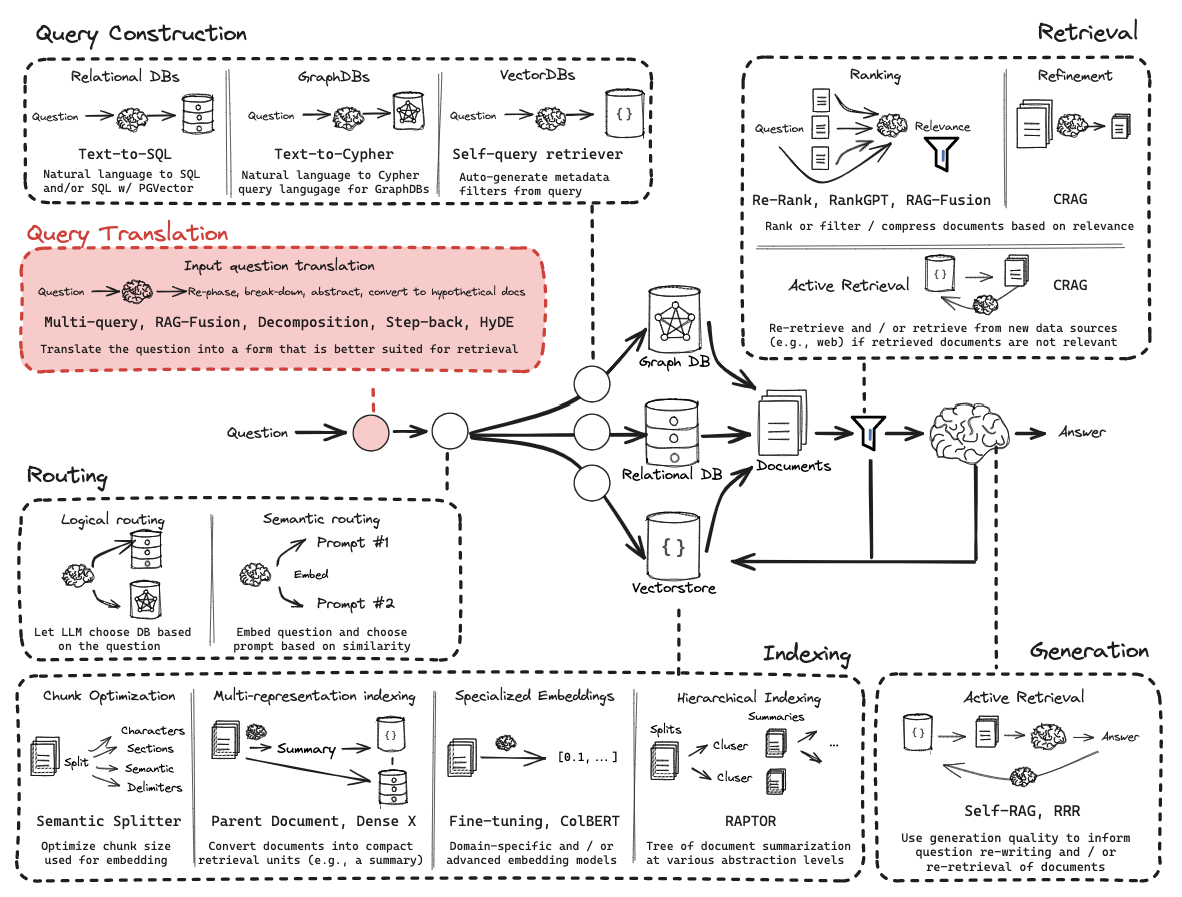

## Enviornment
(1) Packages

In [2]:
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

(2) LangSmith

In [4]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
from dotenv import load_dotenv

LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

(3) API Keys

In [5]:
# os.environ['OPENAI_API_KEY'] = <your-api-key>

## Part 5: Multi Query

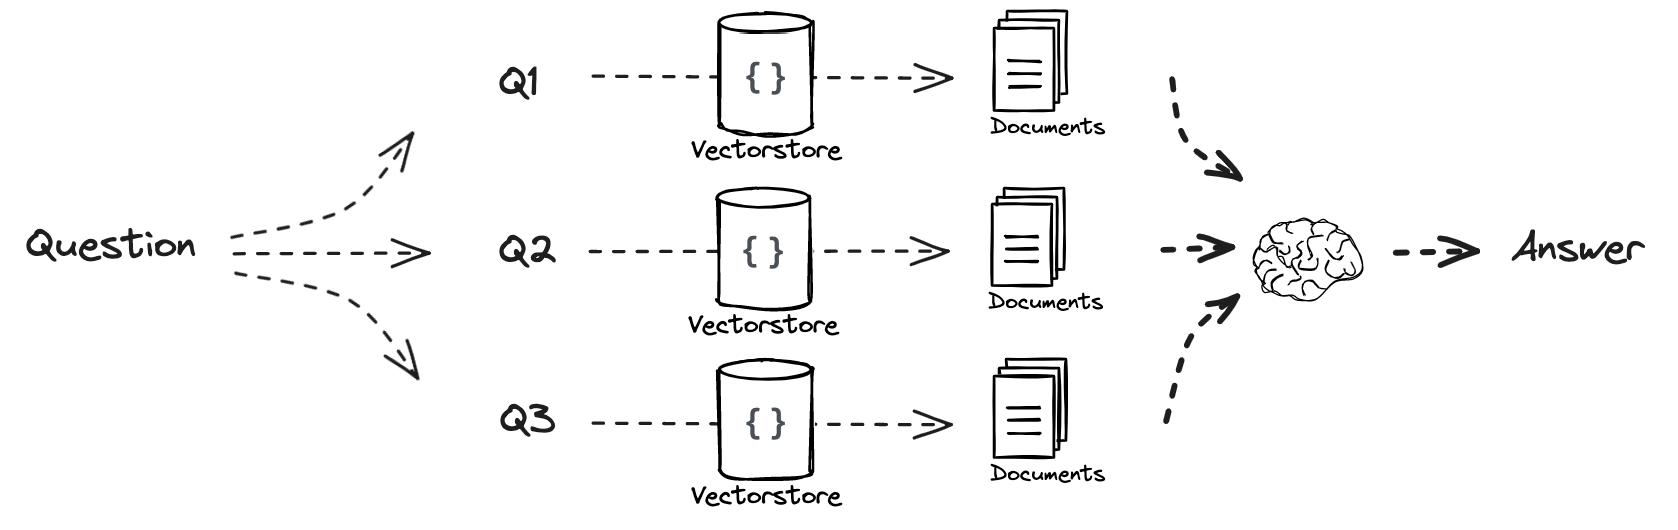

### Index

In [6]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50
)

# Make Splits
splits = text_splitter.split_documents(blog_docs)

# Indexing using HuggingFace embeddings (all-MiniLM-L6-v2)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_42725/2135057265.py:30: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prompt

In [7]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.llms import Ollama  # Use Ollama for local models

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. 
Original question: {question}"""

prompt_perspectives = ChatPromptTemplate.from_template(template=template)

# Use LLaMA 3.2 via Ollama
llm = Ollama(model="llama3.2")

# Generate queries using local LLaMA model
generate_queries = (
    prompt_perspectives
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_42725/3036282750.py:16: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.2")


In [ ]:

from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=0906e14a-13a9-4a7e-93ea-b74b183cff9d; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=6ca5ac92-0c63-4c1d-b79c-8f4a897704ef; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=

11

Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=85f43124-5555-4874-873a-a8eab58e26b2; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=218c38ab-dcc7-482a-a43b-1273c3b12490; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=19ee8560-58f9-48b8-90ad-319e20da5e62; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=3a11e873-99c6-4a69-91fc-092bddee02a2; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=68a59b24-4856-4788-89c7-07df6c175a63; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=06b60c0e-c049-42ac-9501-3b64c92e74d4; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=a87f75a0-46bc-4ee9-ab9e-f51ab0cc2531; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=7f815b89-bdcc-438e-80c9-77effb4930bf; trace=0906e14a-13a9-4a7e-93ea-b74b183cff9d,id=ed77c384-7

In [9]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# llm = ChatOpenAI(temperature=0)
llm = Ollama(model="llama3.2")

final_rag_chain = (
    {"context": retrieval_chain , 
    "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question": question})

"Task decomposition refers to the process of breaking down complex tasks into smaller, more manageable sub-tasks that an agent or autonomous system can handle. In the context of Large Language Model (LLM) agents, task decomposition involves identifying and isolating specific components or sub-problems within a larger task, allowing the LLM to focus on one aspect at a time.\n\nThe article mentions several challenges in task decomposition for LLM agents, including:\n\n1. **Limited context window**: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses.\n2. **Planning over lengthy history**: Planning over a lengthy history and effectively exploring the solution space remain challenging due to the LLM's struggle to adjust plans when faced with unexpected errors.\n3. **Reliability of natural language interface**: The reliability of model outputs is questionable, as LLMs may make formatting errors or exhibit reb

## Part 6: RAG-Fusion

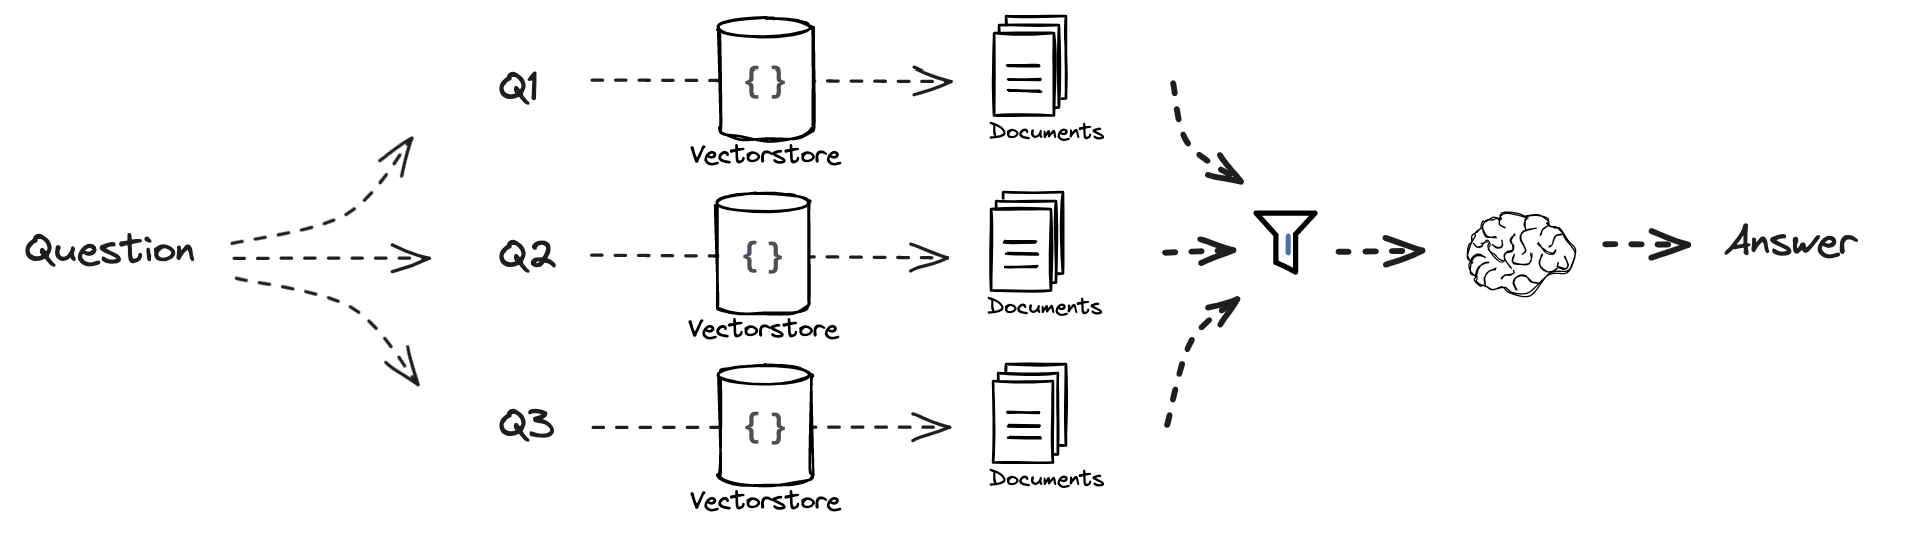

### Prompt

In [10]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """ You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""

prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

llm = Ollama(model="llama3.2")


generate_queries = (
    prompt_rag_fusion
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [12]:
from langchain.load import dumps , loads

def reciprocal_rank_fusion(results: list[list] , k = 60):
    """Reciprocal_rank_fusion that takes multiple lists of ranked documents
    and an optional parameter k used in the RPF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank , doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # if the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RPF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    
    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc) , score)
        for doc , score in sorted(fused_scores.items() , key = lambda x : x[1] , reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question":question})
len(docs)

13

In [13]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """ Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion , 
    "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question": question})

'Task decomposition for LLL (Large Language Models) agents refers to the process of breaking down a complex task into smaller, more manageable sub-tasks that can be tackled one by one.\n\nIn the context of LLM agents, task decomposition is often achieved through a combination of natural language processing (NLP) and reasoning techniques. The agent uses its language generation capabilities to analyze the task requirements, identify key elements, and decompose the task into smaller sub-tasks.\n\nOne approach to task decomposition for LLM agents is to use a template-based framework, such as ReAct (Yao et al. 2023), which incorporates explicit steps for the LLM to think and reason about the task. This involves using a prompt or template that guides the agent to break down the task into smaller sub-tasks, analyze each sub-task, and generate solutions.\n\nFor example, if the task is "develop a novel anticancer drug", the ReAct prompt might look like this:\n\n"Develop a novel anticancer drug:

## Part 7: Decomposition

In [14]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """ You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [15]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.llms import Ollama

# LLM
llm = Ollama(model="llama3.2")

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x : x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question": question})

In [16]:
questions

['Here are three potential search queries that could lead to isolatable sub-problems or sub-questions related to "What are the main components of an LLM-powered autonomous agent system?":',
 '',
 '1. **"Components of a self-aware AI system with language models"**',
 '',
 'This query targets the specific aspect of an autonomous agent system that incorporates Large Language Models (LLMs) and explores what makes up this complex system.',
 '',
 '2. **"Architecture of a human-AI hybrid autonomous agent"**',
 '',
 'This sub-question delves into the design and structure of LLM-powered autonomous agents, examining how humans and AI collaborate or integrate within the system.',
 '',
 '3. **"LLM integration in decision-making for autonomous systems"**',
 '',
 'This query zeroes in on the specific mechanism by which language models contribute to the decision-making processes within an autonomous agent system, exploring how they inform and influence action-taking.',
 '',
 'These queries can serve 

Answer recursively

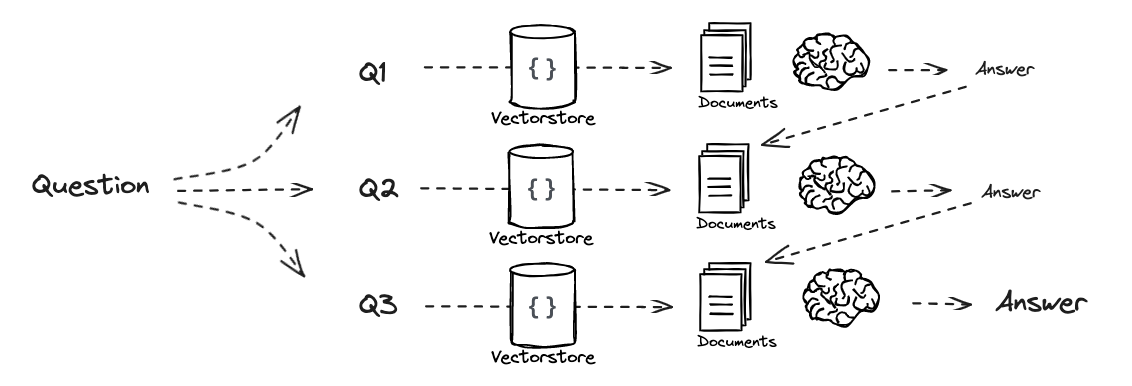

In [17]:
# Prompt
template = """ Here is the question you need to answer:
\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [18]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question , answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# LLM
llm = Ollama(model="llama3.2")

q_a_pairs = ""
for q in questions:

    rag_chain = (
        {"context": itemgetter("question") | retriever,
        "question": itemgetter("question") , 
        "q_a_pairs": itemgetter("q_a_pairs")}
        | decomposition_prompt
        | llm
        | StrOutputParser()
    )

    answer = rag_chain.invoke({"question":q , "q_a_pairs": q_a_pairs})
    q_a_pairs = format_qa_pair(q , answer)
    q_a_pairs = q_a_pairs + "\n---\n" + q_a_pairs

In [19]:
answer

'Based on the provided context, it appears that the LLM-powered autonomous agent system involves multiple components, including planning, task decomposition, and search. The system uses various prompting techniques, such as chain of thought (CoT) and tree of thoughts (Yao et al. 2023), to decompose complex tasks into smaller and simpler steps.\n\nTo better understand how these prompts are used in the context of LLM-powered autonomous agent systems, consider the following potential research questions:\n\n1. **How do different prompting techniques for task decomposition impact the performance of LLM-powered autonomous agents?**\n\nAnswer: Research has shown that certain prompting techniques, such as CoT and tree of thoughts, can be more effective than others in decomposing complex tasks into smaller steps.\n\n2. **What is the optimal way to incorporate human inputs into the prompting process for task decomposition in LLM-powered autonomous agent systems?**\n\nAnswer: Human-inputted promp

Answer individually

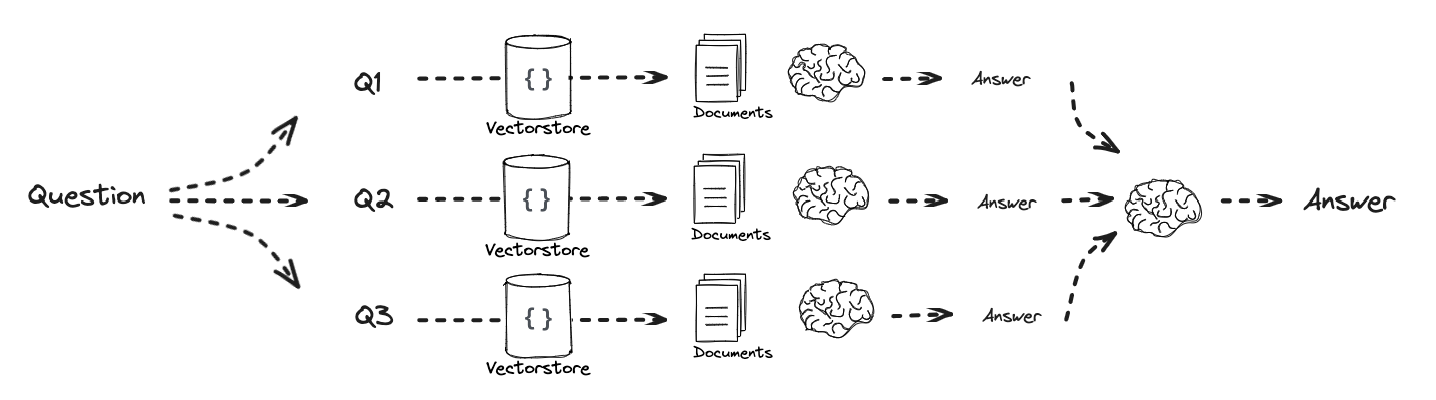

In [20]:
# Answer each sub-question individually

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough , RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_community.llms import Ollama

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question , prompt_rag , sub_question_generator_chain):
    """RAG on rach sub-question"""

    # Use out decomposition /
    sub_questions = sub_question_generator_chain.invoke({"question":question})

    # Initialize a list to hold RAG chain results
    rag_results = []

    for sub_question in sub_questions:

        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)

        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs , "question": sub_question})

        rag_results.append(answer)
    
    return rag_results , sub_questions

# Wrap the retrieval of RAG process in a RunnableLambda for integration into a chain
answers , questions = retrieve_and_rag(question , prompt_rag , generate_queries_decomposition)

/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_42725/517961021.py:24: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [21]:
def format_qa_pairs(questions , answers):
    """Format Q and A pairs"""

    formatted_string = ""
    for i , (question , answer) in enumerate(zip(questions , answers) , start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    
    return formatted_string.strip()

context = format_qa_pairs(questions , answers)

# Prompt
template = """Here is a set of Q + A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)
final_rag_chain.invoke({"context":context,"question":question})

'Based on the provided Q&A pairs, the three key components of an LLM-powered autonomous agent system are:\n\n1. Planning: This includes techniques such as subgoal and decomposition (e.g., using Chain of Thought or Tree of Thoughts), task decomposition, and breaking down large tasks into smaller subgoals.\n2. Reflection and refinement: This involves self-criticism, learning from mistakes, and improving results through reflection and refinement processes.\n3. Memory: Utilizing external tools or interfaces (e.g., PDDL) for long-horizon planning and task decomposition.\n\nThese components work together to enable the LLM-powered autonomous agent system to reason, learn, and adapt in complex environments, making it capable of taking decisions in various scenarios.'

## Part 8: Step Back

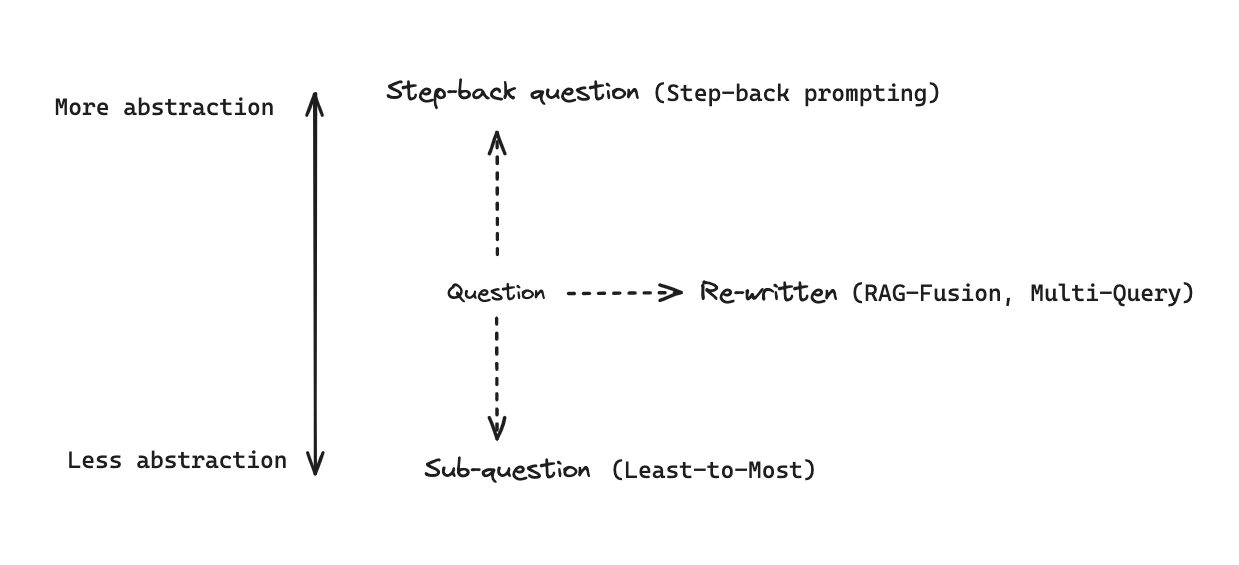

In [22]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate , FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to examples messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt = example_prompt , 
    examples = examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [23]:
generate_queries_step_back = prompt | llm | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question":question})

'I\'ll paraphrase your question to make it more generic and easier to answer. \n\nCould you please rephrase the question "What is the origin of The Police band\'s drummer Stewart Copeland?" into a simpler question?'

In [24]:
# Response prompt
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.
# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context":generate_queries_step_back | retriever ,
        # Pass on the question
        "question": lambda x : x["question"] , 
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question":question})


"Task decomposition is a crucial component of LLM-powered autonomous agent systems, enabling efficient handling of complex tasks by breaking them down into smaller, manageable subgoals. In the context of LLM agents, task decomposition involves using natural language processing (NLP) techniques to decompose large tasks into smaller, more manageable pieces.\n\nThere are three primary methods for task decomposition in LLM-powered autonomous agent systems:\n\n1. **Simple prompting**: The LLM is instructed to generate a list of subtasks or subgoals that can be achieved by breaking down the original task. This method relies on the LLM's ability to understand the context and nuances of the task, as well as its capacity for creative problem-solving.\n2. **Prompt templates**: A pre-defined prompt template is used to guide the LLM in generating a list of subtasks or subgoals. These templates typically include a brief description of the task, followed by a set of instructions that specify how the

## Part 9: HyDE

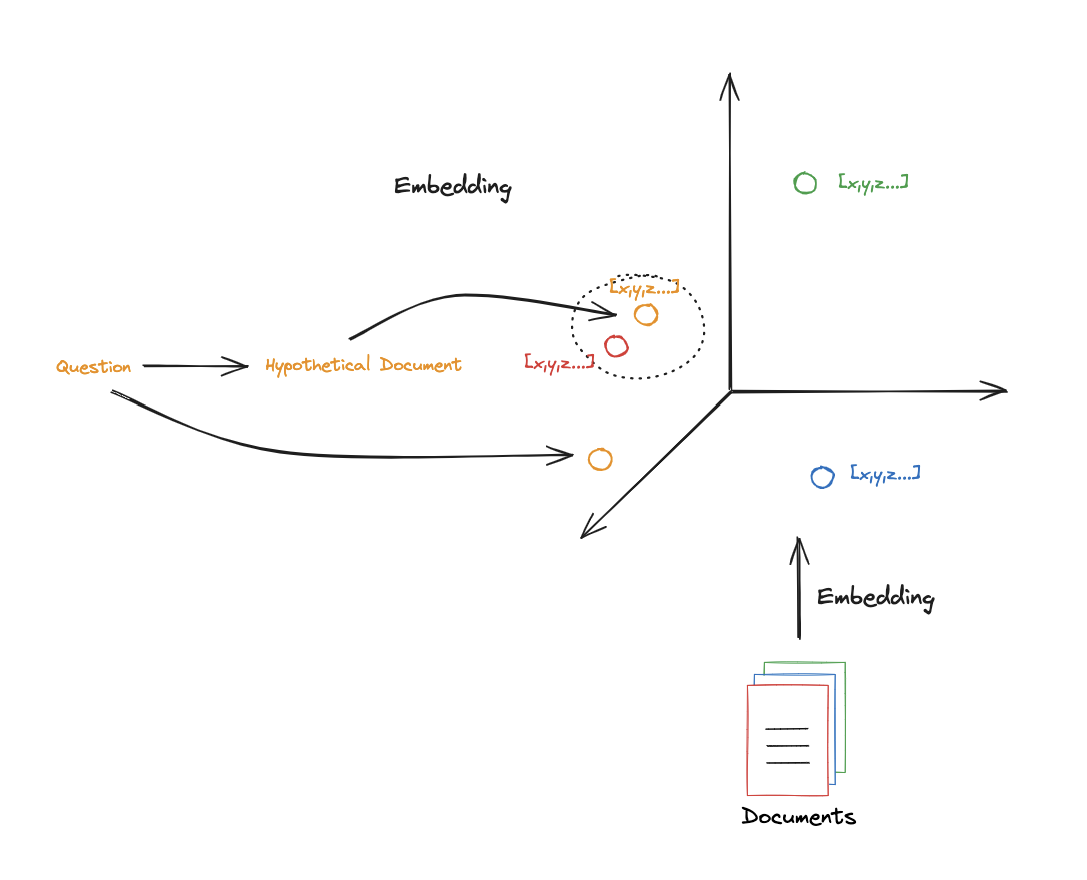

In [25]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

llm = Ollama(model = 'llama3.2')

generate_docs_for_retrieval = (
    prompt_hyde | llm | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

'Title: Task Decomposition for Large Language Model (LLM) Agents: A Framework for Hierarchical and Adaptive Problem-Solving\n\nAbstract:\nTask decomposition is a crucial concept in artificial intelligence that involves breaking down complex tasks into smaller, manageable sub-tasks. In the context of Large Language Model (LLM) agents, task decomposition refers to the process of decomposing complex tasks into a hierarchical sequence of sub-tasks that can be addressed by the LLM agent through sequential reasoning and inference. This framework enables LLM agents to adaptively solve problems with varying levels of complexity and ambiguity.\n\nIntroduction:\nLarge Language Models (LLMs) have gained significant attention in recent years due to their impressive performance on a wide range of natural language processing tasks. However, their ability to generalize to novel situations and handle complex tasks remains limited. Task decomposition provides an effective solution to this challenge by 

In [26]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them less robust compared to humans who learn from trial and error.\n\n\nReliability of natural language interface: Current agent system relies on natural 

In [27]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

'Task decomposition for LLM (Large Language Model) agents involves breaking down complex tasks into smaller, manageable subgoals. This can be done through several methods:\n\n1. Simple prompting: Using prompts like "Steps for XYZ." or "What are the subgoals for achieving XYZ."\n2. Task-specific instructions: Providing specific instructions, such as "Write a story outline." for writing a novel.\n3. Human inputs: Receiving input from humans to assist with task decomposition.\n\nThe goal of task decomposition is to enable efficient handling of complex tasks by identifying smaller, more manageable steps that can be completed individually.'